In [7]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from datetime import datetime
import itertools
from tqdm import tqdm
import torch
import geopandas as gpd

In [8]:
import os
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim import lr_scheduler
import torch

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


2.2.0
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [9]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
frontiers = gpd.read_file((gpd.datasets.get_path('naturalearth_lowres')))

/tmp/ipykernel_114790/1144883926.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_cities' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
ERROR 1: PROJ: proj_create_from_database: Open of /home/blackswan/anaconda3/share/proj failed
/tmp/ipykernel_114790/1144883926.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  frontiers = gpd.read_file((gpd.datasets.get_path('naturalearth_lowres')))


In [10]:
cities.head()

name                    geometry
0  Vatican City   POINT (12.45339 41.90328)
1    San Marino   POINT (12.44177 43.93610)
2         Vaduz    POINT (9.51667 47.13372)
3       Lobamba  POINT (31.20000 -26.46667)
4    Luxembourg    POINT (6.13000 49.61166)

In [11]:
frontiers.head()

pop_est      continent                      name iso_a3  gdp_md_est  \
0     889953.0        Oceania                      Fiji    FJI        5496   
1   58005463.0         Africa                  Tanzania    TZA       63177   
2     603253.0         Africa                 W. Sahara    ESH         907   
3   37589262.0  North America                    Canada    CAN     1736425   
4  328239523.0  North America  United States of America    USA    21433226   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [12]:
df_events=pd.read_csv('ged201.csv' ,dtype={'gwnoa': object})

In [13]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225385 entries, 0 to 225384
Data columns (total 49 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 225385 non-null  int64  
 1   relid              225385 non-null  object 
 2   year               225385 non-null  int64  
 3   active_year        225385 non-null  int64  
 4   code_status        225385 non-null  object 
 5   type_of_violence   225385 non-null  int64  
 6   conflict_dset_id   225385 non-null  int64  
 7   conflict_new_id    225385 non-null  int64  
 8   conflict_name      225385 non-null  object 
 9   dyad_dset_id       225385 non-null  int64  
 10  dyad_new_id        225385 non-null  int64  
 11  dyad_name          225385 non-null  object 
 12  side_a_dset_id     225385 non-null  int64  
 13  side_a_new_id      225385 non-null  int64  
 14  side_a             225385 non-null  object 
 15  side_b_dset_id     225385 non-null  int64  
 16  si

In [14]:
print(f'{len(df_events.latitude)/len (df_events)*100}%')

100.0%


In [15]:
print(f'{len(df_events.longitude)/len (df_events)*100}%')


100.0%


In [16]:
serie_noNan=df_events.isna().sum()==0

In [17]:
df_nonNan=pd.DataFrame(serie_noNan, columns=['valid'])

In [18]:
df_nonNan.index

Index(['id', 'relid', 'year', 'active_year', 'code_status', 'type_of_violence',
       'conflict_dset_id', 'conflict_new_id', 'conflict_name', 'dyad_dset_id',
       'dyad_new_id', 'dyad_name', 'side_a_dset_id', 'side_a_new_id', 'side_a',
       'side_b_dset_id', 'side_b_new_id', 'side_b', 'number_of_sources',
       'source_article', 'source_office', 'source_date', 'source_headline',
       'source_original', 'where_prec', 'where_coordinates',
       'where_description', 'adm_1', 'adm_2', 'latitude', 'longitude',
       'geom_wkt', 'priogrid_gid', 'country', 'country_id', 'region',
       'event_clarity', 'date_prec', 'date_start', 'date_end', 'deaths_a',
       'deaths_b', 'deaths_civilians', 'deaths_unknown', 'best', 'high', 'low',
       'gwnoa', 'gwnob'],
      dtype='object')

In [19]:
df_nonNan = df_nonNan[df_nonNan.valid==True]

In [20]:
df_nonNan.index

Index(['id', 'relid', 'year', 'active_year', 'code_status', 'type_of_violence',
       'conflict_dset_id', 'conflict_new_id', 'conflict_name', 'dyad_dset_id',
       'dyad_new_id', 'dyad_name', 'side_a_dset_id', 'side_a_new_id', 'side_a',
       'side_b_dset_id', 'side_b_new_id', 'side_b', 'number_of_sources',
       'where_prec', 'where_coordinates', 'latitude', 'longitude', 'geom_wkt',
       'priogrid_gid', 'country', 'country_id', 'region', 'event_clarity',
       'date_prec', 'date_start', 'date_end', 'deaths_a', 'deaths_b',
       'deaths_civilians', 'deaths_unknown', 'best', 'high', 'low'],
      dtype='object')

In [21]:
df_dataset= df_events[df_nonNan.index]

In [22]:
df_dataset

id               relid  year  active_year code_status  \
0       244657  IRQ-2017-1-524-322  2017            1       Clear   
1       132140    AFG-1989-1-411-2  1989            1       Clear   
2       130364   AFG-1989-1-411-37  1989            1       Clear   
3       130359    AFG-1989-1-411-4  1989            1       Clear   
4       133883   AFG-1989-1-411-39  1989            1       Clear   
...        ...                 ...   ...          ...         ...   
225380   15525   MZM-1989-3-1347-4  1989            1       Clear   
225381   15524  MZM-1989-3-1347-16  1989            1       Clear   
225382   15245  MZM-1990-3-1347-18  1990            1       Clear   
225383   15516  MZM-1990-3-1347-28  1990            1       Clear   
225384   15493  MZM-1990-3-1347-29  1990            1       Clear   

        type_of_violence  conflict_dset_id  conflict_new_id  \
0                      1               259              259   
1                      1               333              333   
2                      1               333              333   
3                      1               333              333   
4                      1               333              333   
...                  ...               ...              ...   
225380                 3               498              562   
225381                 3               498              562   
225382                 3               498              562   
225383                 3               498              562   
225384                 3               498              562   

                  conflict_name  dyad_dset_id  ...  date_prec  \
0              Iraq: Government           524  ...          1   
1       Afghanistan: Government           724  ...          3   
2       Afghanistan: Government           724  ...          2   
3       Afghanistan: Government           724  ...          2   
4       Afghanistan: Government           724  ...          3   
...                         ...           ...  ...        ...   
225380       Renamo - Civilians           498  ...          3   
225381       Renamo - Civilians           498  ...          3   
225382       Renamo - Civilians           498  ...          2   
225383       Renamo - Civilians           498  ...          3   
225384       Renamo - Civilians           498  ...          1   

                     date_start                 date_end  deaths_a deaths_b  \
0       2017-07-31 00:00:00.000  2017-07-31 00:00:00.000         0        4   
1       1989-01-07 00:00:00.000  1989-01-13 00:00:00.000         6        0   
2       1989-01-15 00:00:00.000  1989-01-18 00:00:00.000         0        0   
3       1989-01-23 00:00:00.000  1989-01-24 00:00:00.000         0        0   
4       1989-01-30 00:00:00.000  1989-02-05 00:00:00.000         0        0   
...                         ...                      ...       ...      ...   
225380  1989-03-18 00:00:00.000  1989-03-24 00:00:00.000         0        0   
225381  1989-07-09 00:00:00.000  1989-07-15 00:00:00.000         0        0   
225382  1990-06-07 00:00:00.000  1990-06-10 00:00:00.000         0        0   
225383  1990-11-17 00:00:00.000  1990-11-23 00:00:00.000         0        0   
225384  1990-11-25 00:00:00.000  1990-11-25 00:00:00.000         0        0   

        deaths_civilians  deaths_unknown best  high  low  
0                      0               2    6     6    6  
1                      0               0    6     6    6  
2                      0               4    4     4    0  
3                      0             600  600   600  600  
4                      0               2    2     2    0  
...                  ...             ...  ...   ...  ...  
225380                 9               0    9     9    9  
225381                 9               0    9     9    9  
225382                 7               0    7     7    7  
225383                 1               0    1     1    1  
225384                 6               0    6  

In [23]:
df_dataset['type_of_violence']=df_dataset['type_of_violence'].astype(str)

/tmp/ipykernel_114790/2021545456.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset['type_of_violence']=df_dataset['type_of_violence'].astype(str)


In [24]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225385 entries, 0 to 225384
Data columns (total 39 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 225385 non-null  int64  
 1   relid              225385 non-null  object 
 2   year               225385 non-null  int64  
 3   active_year        225385 non-null  int64  
 4   code_status        225385 non-null  object 
 5   type_of_violence   225385 non-null  object 
 6   conflict_dset_id   225385 non-null  int64  
 7   conflict_new_id    225385 non-null  int64  
 8   conflict_name      225385 non-null  object 
 9   dyad_dset_id       225385 non-null  int64  
 10  dyad_new_id        225385 non-null  int64  
 11  dyad_name          225385 non-null  object 
 12  side_a_dset_id     225385 non-null  int64  
 13  side_a_new_id      225385 non-null  int64  
 14  side_a             225385 non-null  object 
 15  side_b_dset_id     225385 non-null  int64  
 16  si

In [25]:
df_dataset.type_of_violence.head()

0    1
1    1
2    1
3    1
4    1
Name: type_of_violence, dtype: object

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
plt.suptitle(f'densité des zones de conflit par état ', fontsize=16)
ax1.pie(df_dataset.country.value_counts(),labels=df_dataset.country.value_counts().index)


In [26]:
gdf = gpd.GeoDataFrame(
    df_dataset, geometry=gpd.points_from_xy(df_dataset.longitude, df_dataset.latitude), crs="EPSG:4326"
)

In [27]:
gdf.region.unique()

array(['Asia', 'Europe', 'Africa', 'Americas', 'Middle East'],
      dtype=object)

In [28]:
gdf.type_of_violence.value_counts()

type_of_violence
1    166379
3     36083
2     22923
Name: count, dtype: int64

# Type of violence for year selected by region
## 1: state-based conflict, 
## 2: non-state conflict, 
## 3: one-sided violence

In [29]:
 def hot_point_by_year(year):
    
    year_hot_point=gdf[gdf.year==year]
    for region in gdf.region.unique():
        fig, ax = plt.subplots(figsize=(10, 10))
        gdf.plot(ax=ax)
        color_dict = {'1':'red', '2':'orange', '3':'pink'}

        xmin, ymin, xmax, ymax = gdf[gdf.region == region].total_bounds
        pad = 5  # add a padding around the geometry
        ax.set_xlim(xmin-pad, xmax+pad)
        ax.set_ylim(ymin-pad, ymax+pad)
        # We can now plot our ``GeoDataFrame``.
        frontiers.plot(ax=ax)
        year_hot_point.plot(ax=ax, column="type_of_violence", cmap=matplotlib.colors.ListedColormap(list(color_dict.values())) ,legend=True) 
        plt.title(f'Region: {region}, Année: {year}')

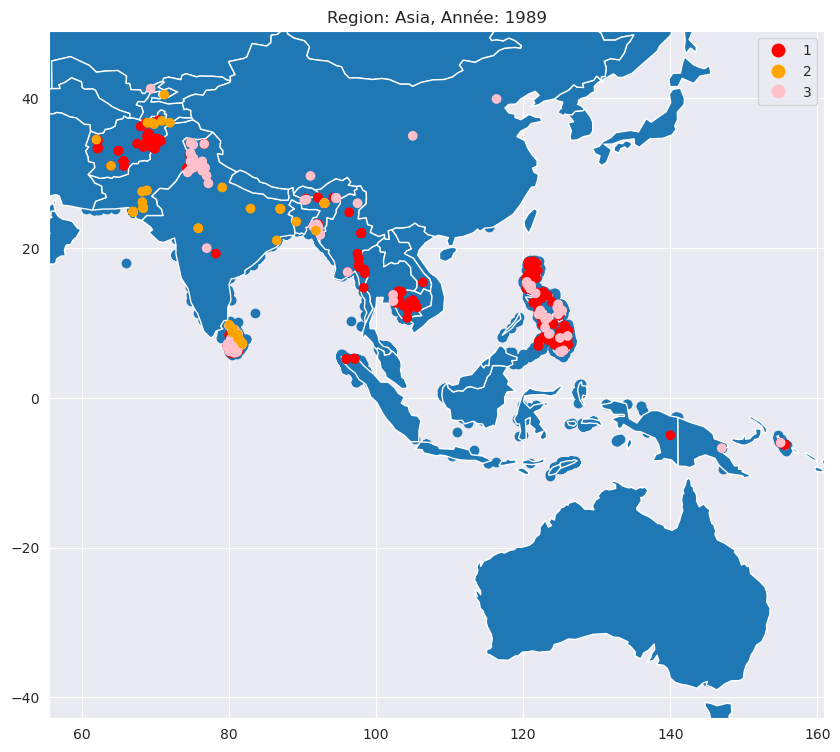

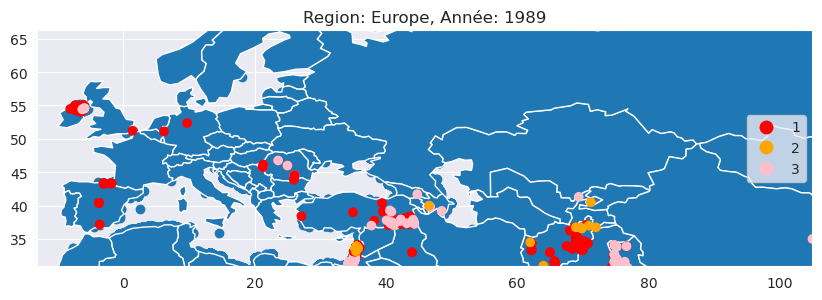

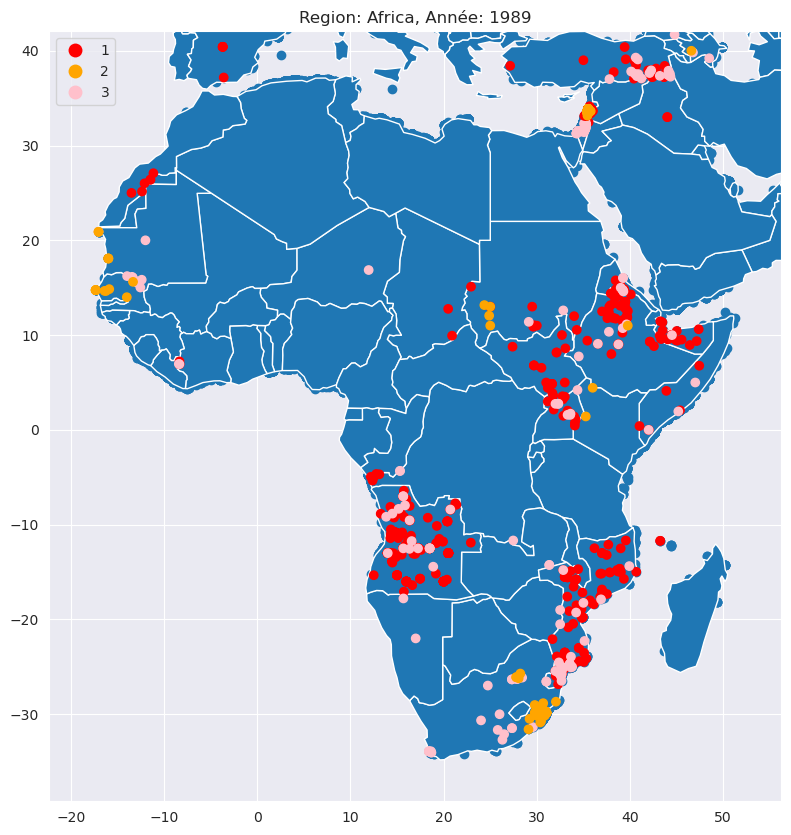

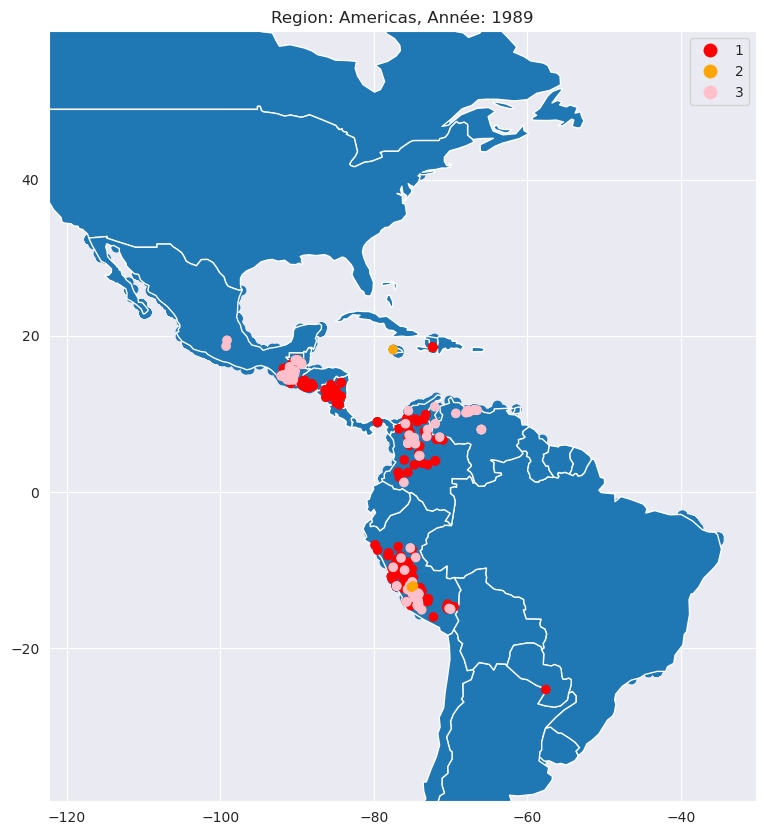

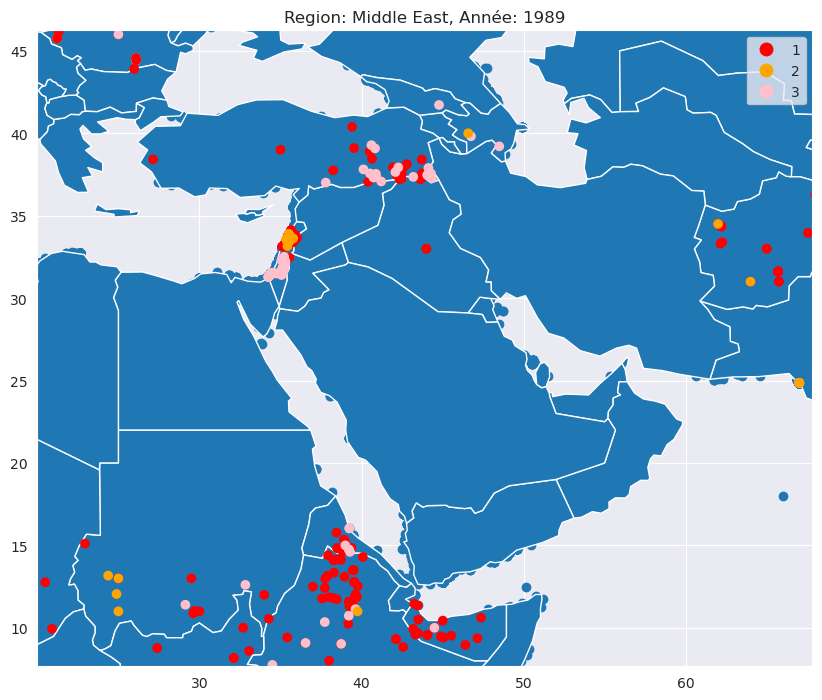

In [30]:
hot_point_by_year(1989)

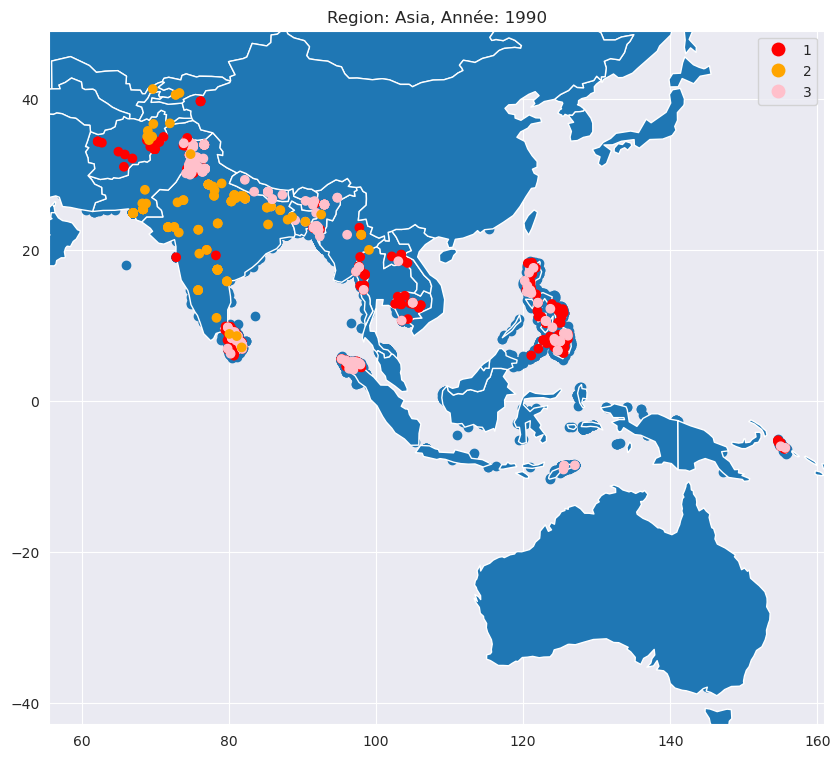

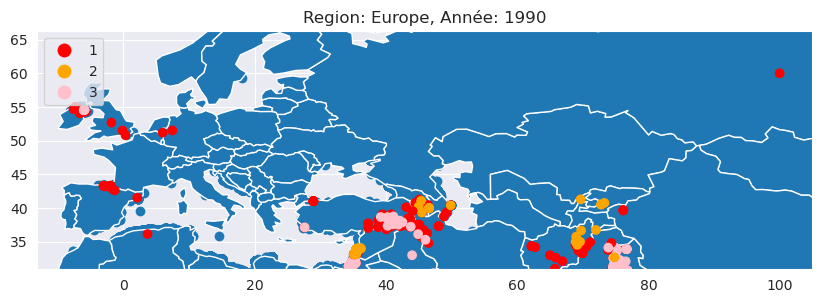

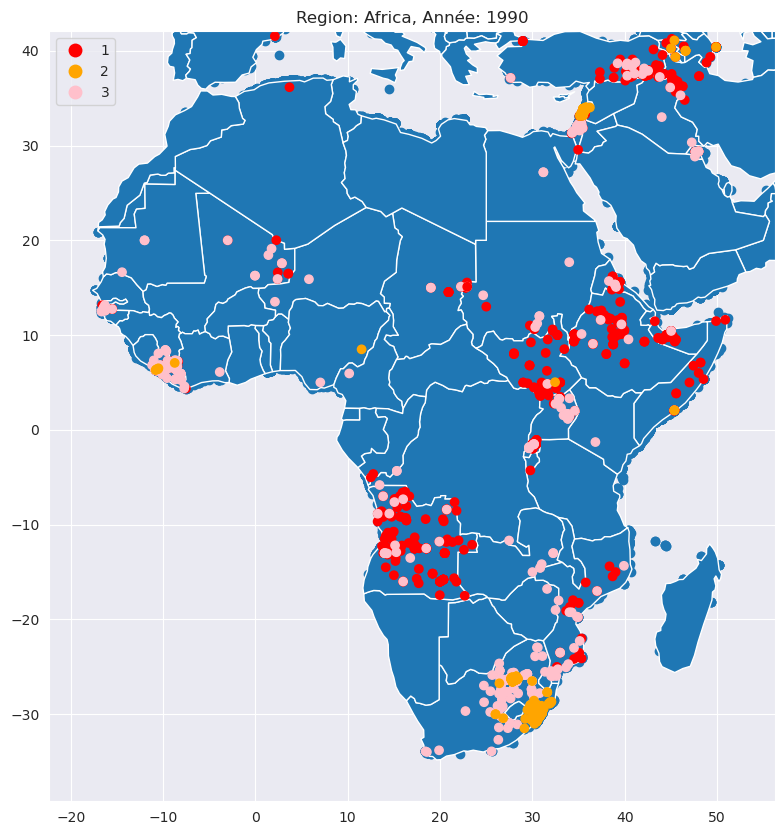

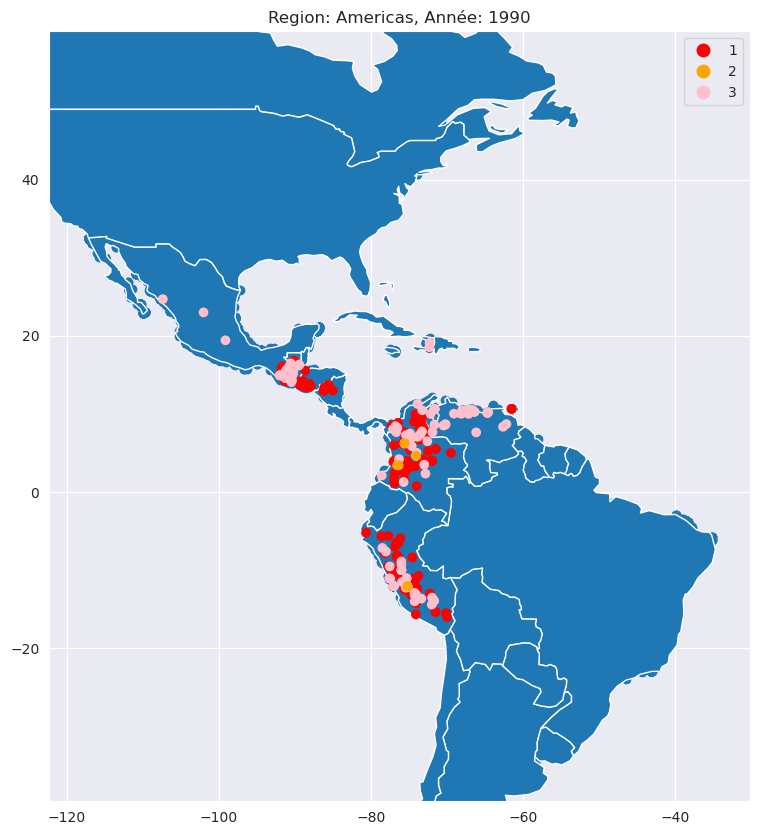

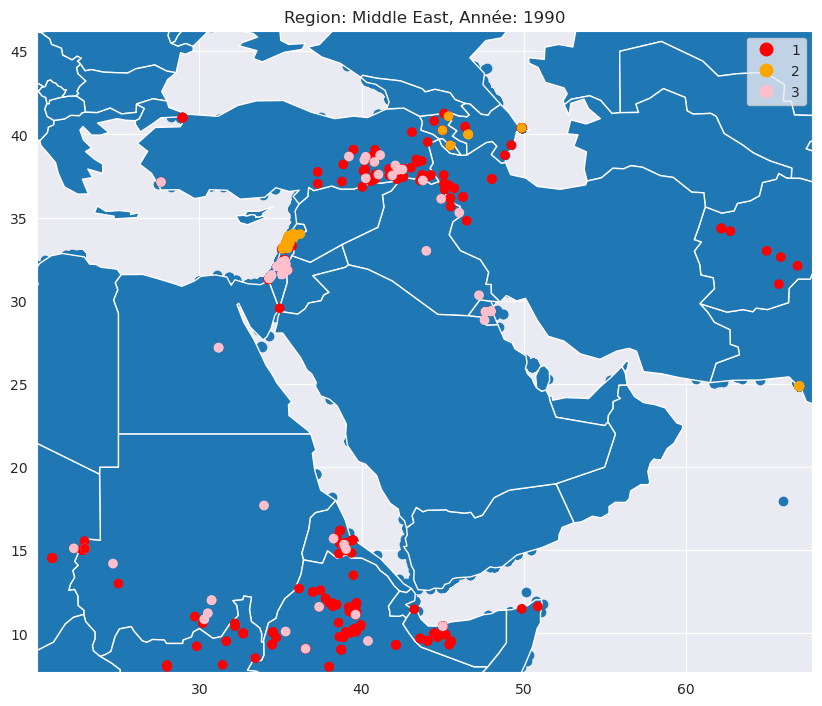

In [31]:
hot_point_by_year(1990)

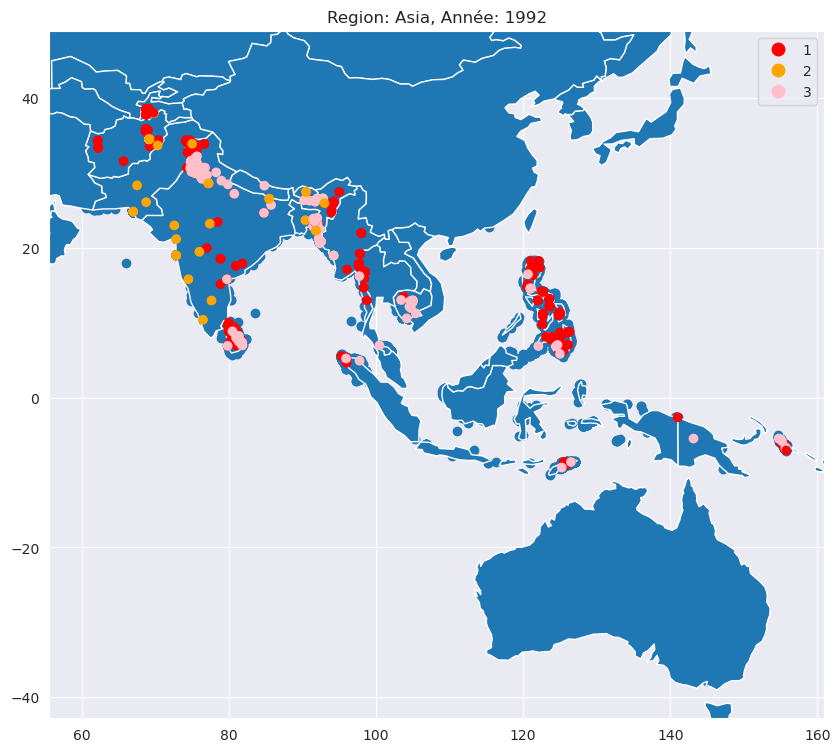

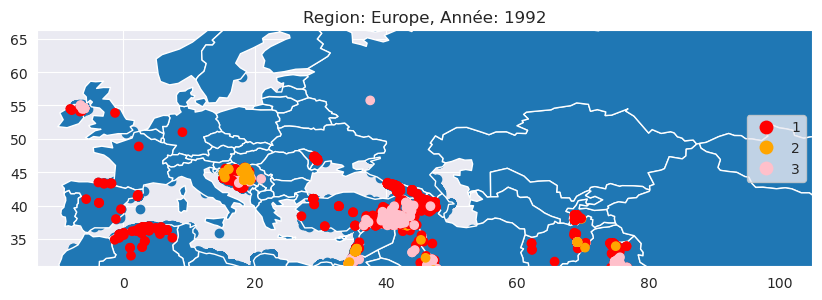

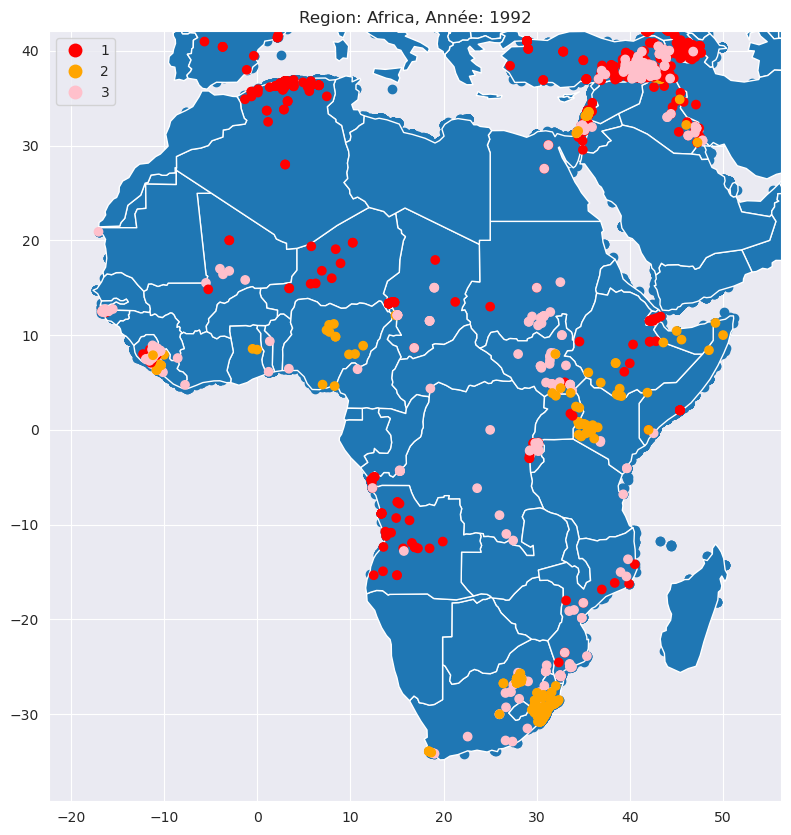

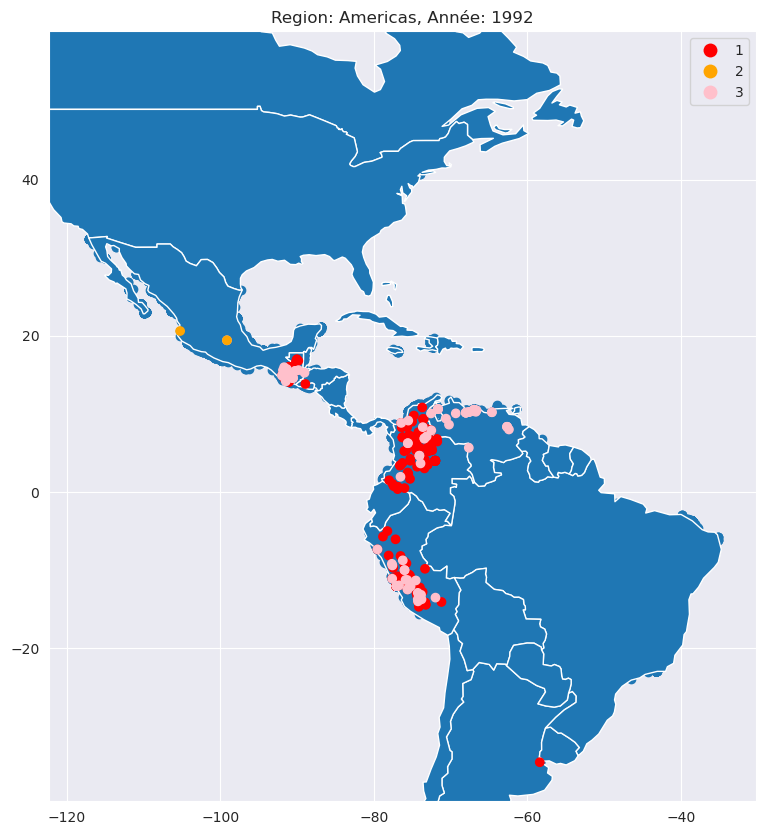

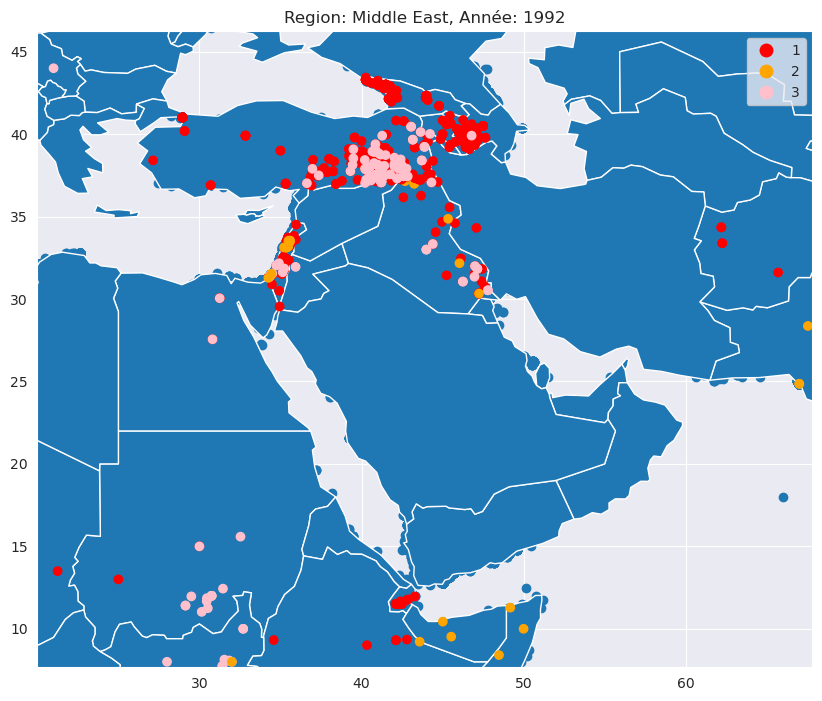

In [32]:
hot_point_by_year(1992)

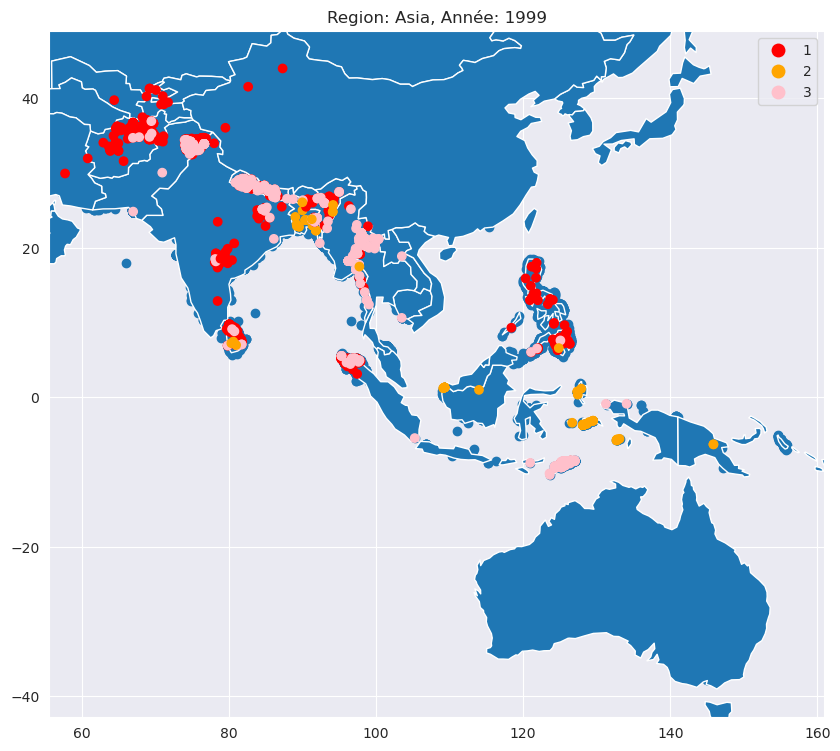

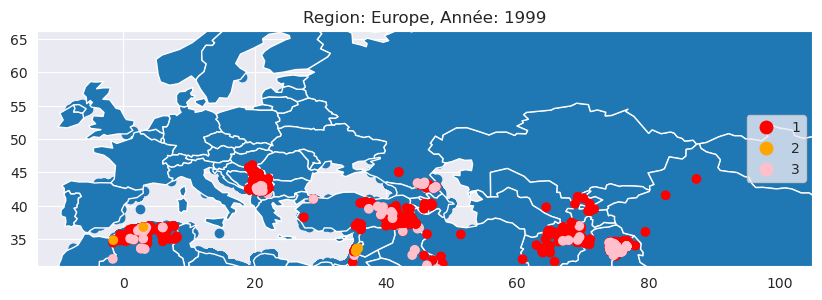

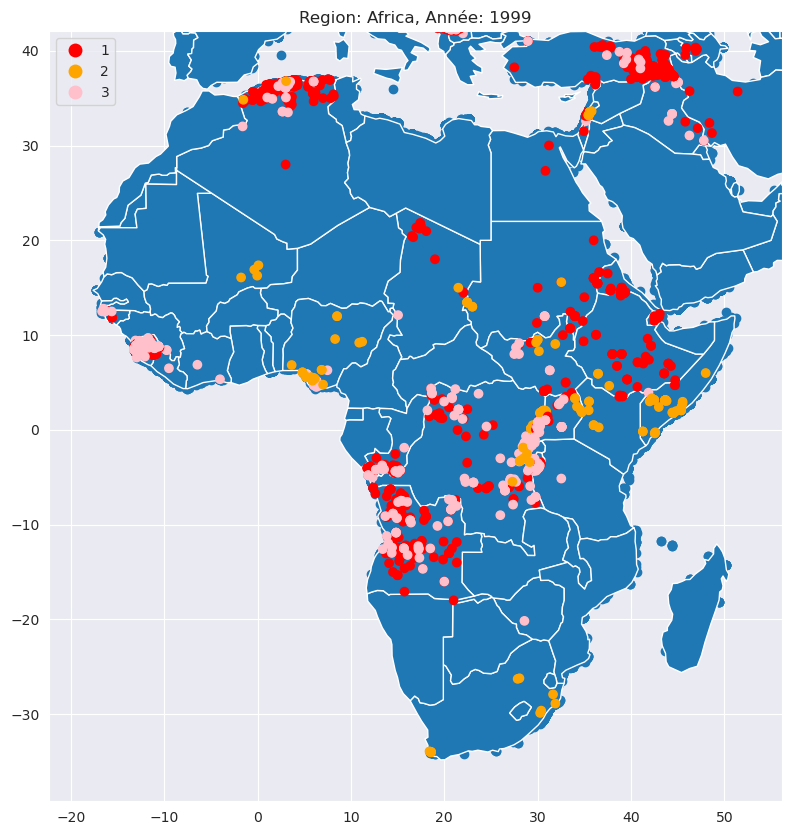

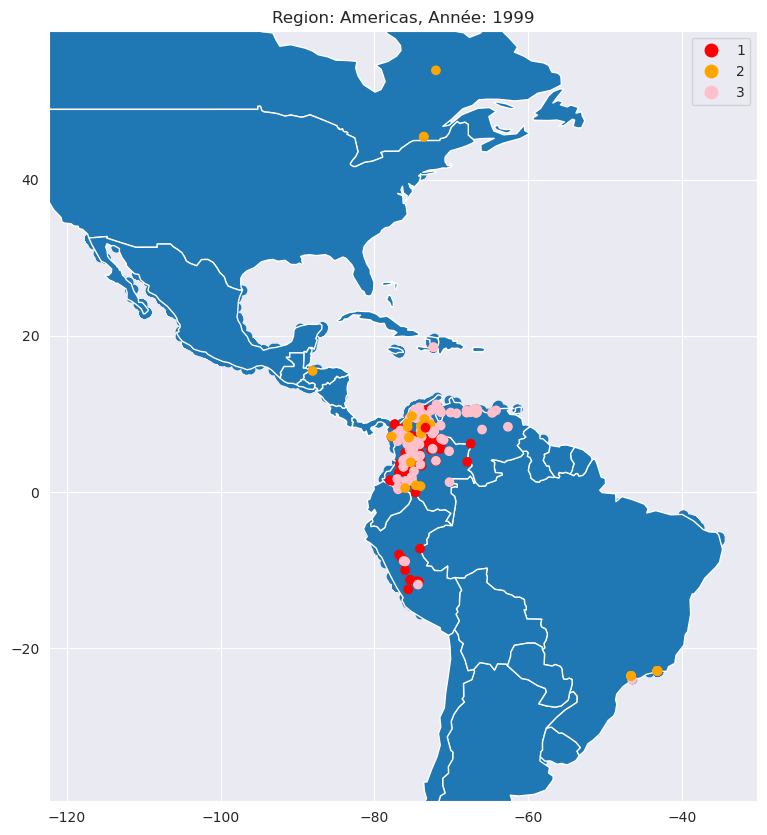

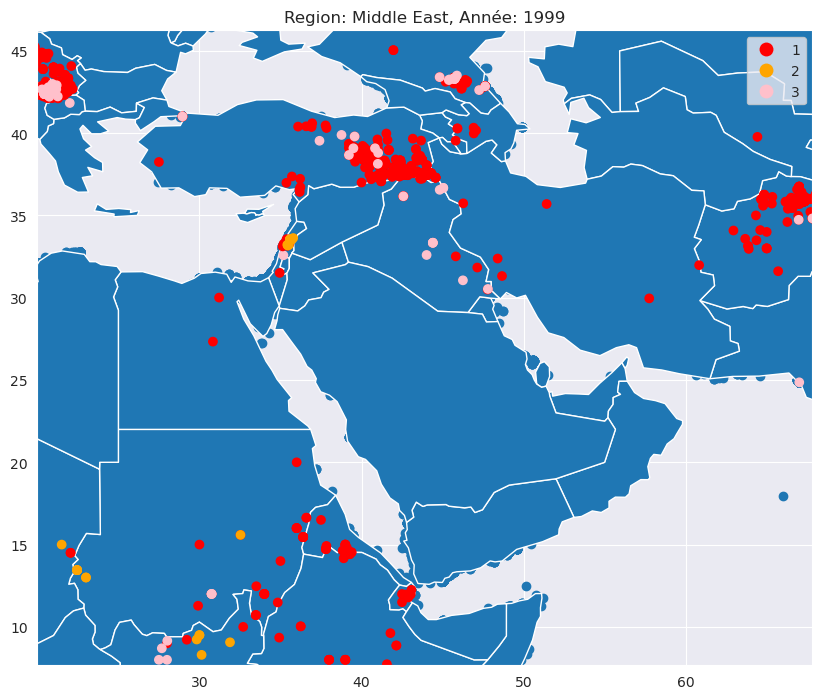

In [33]:
hot_point_by_year(1999)

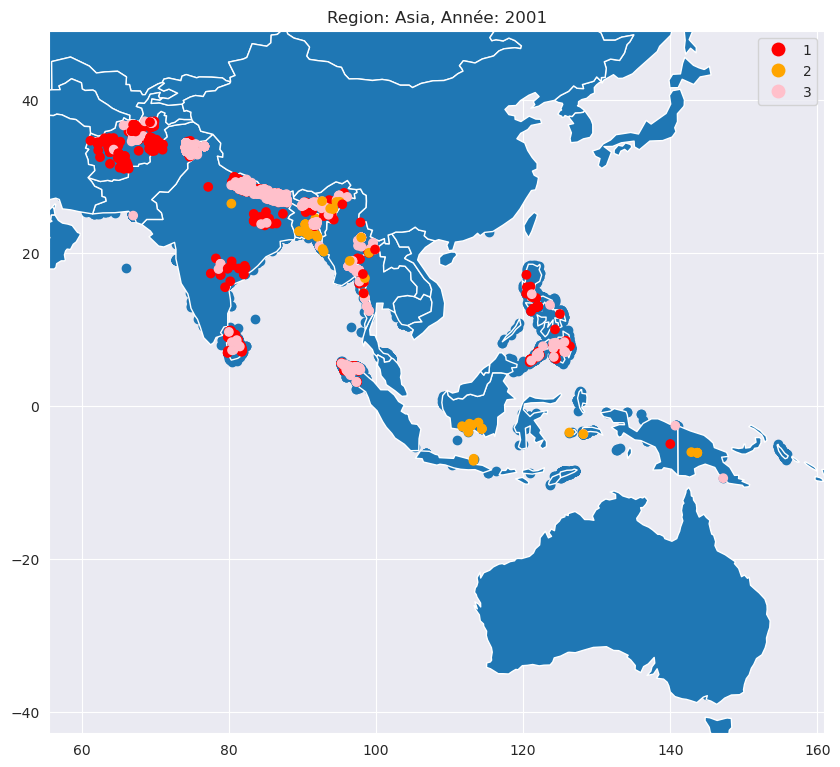

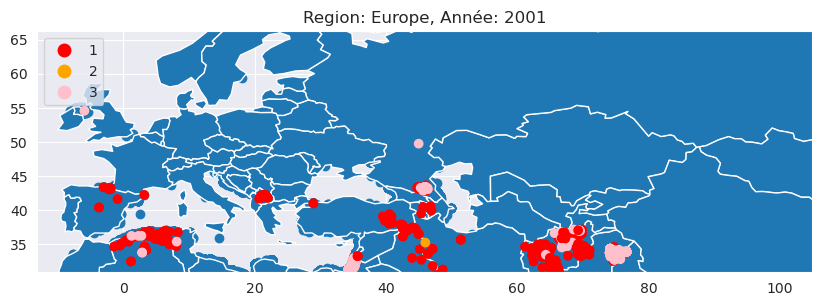

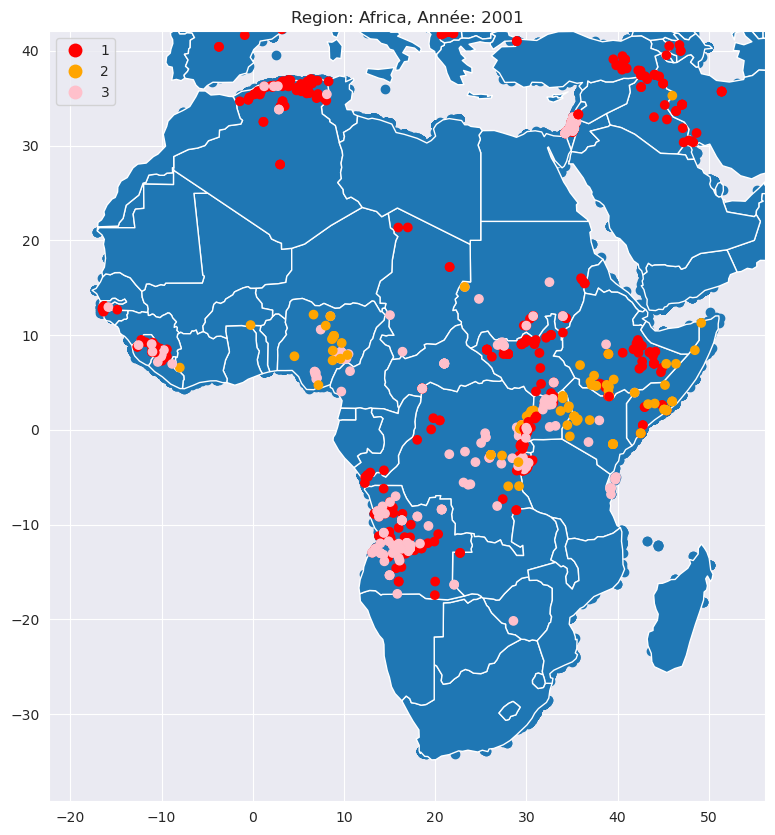

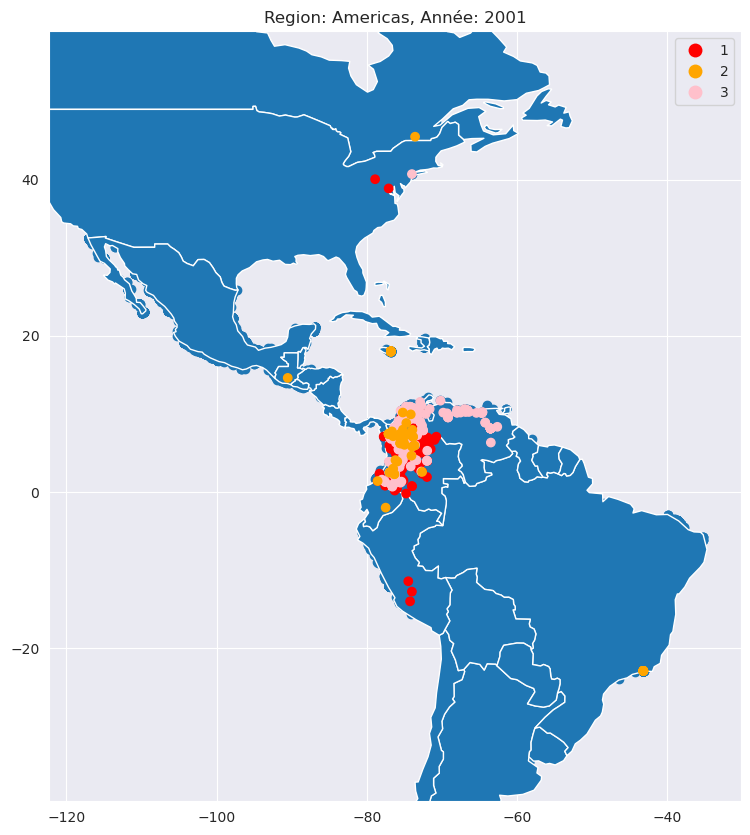

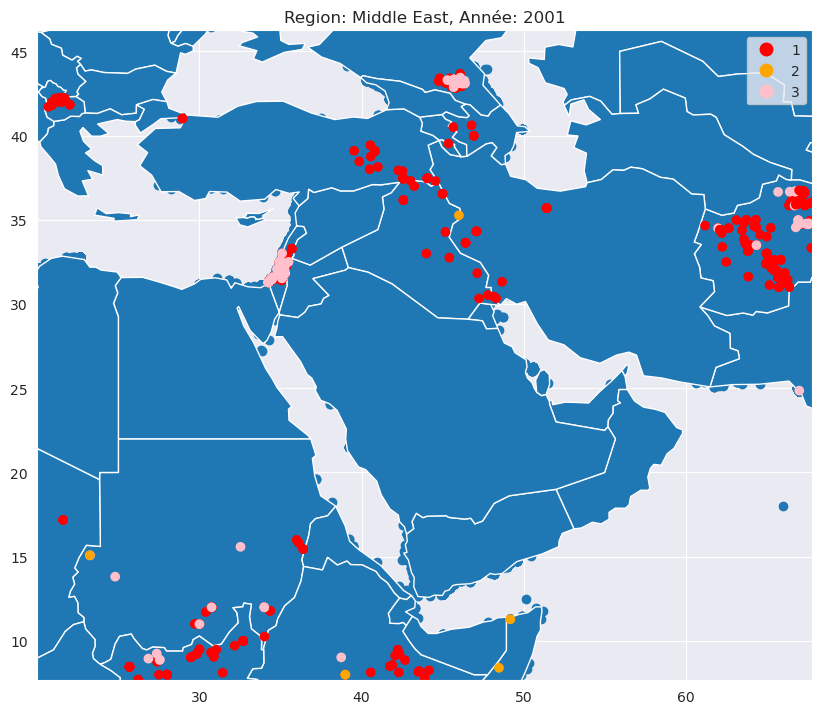

In [34]:
hot_point_by_year(2001)

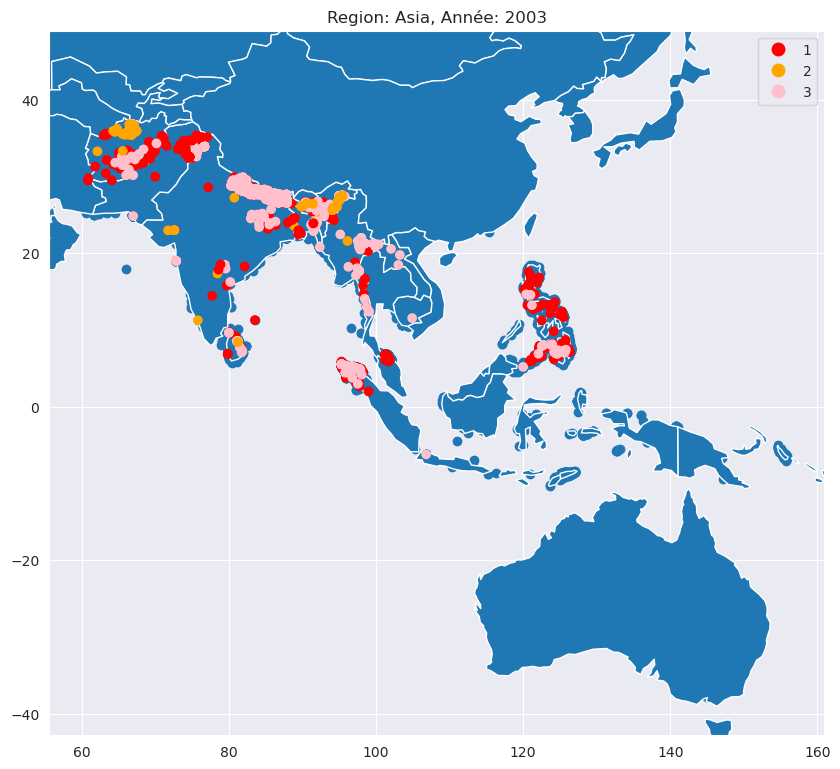

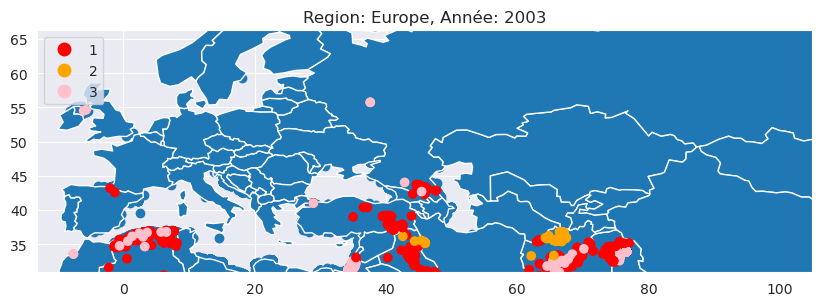

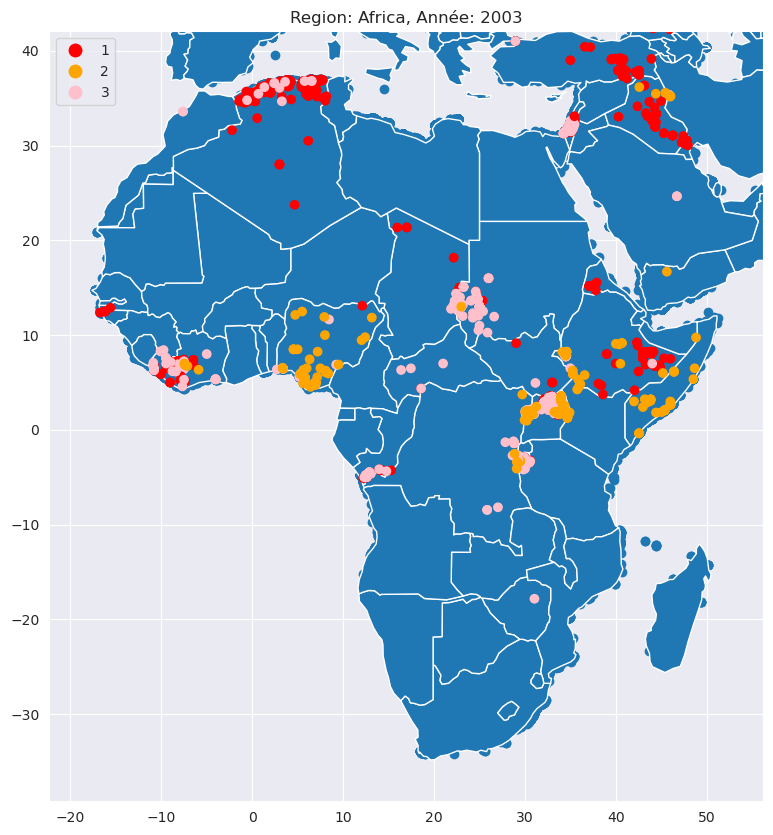

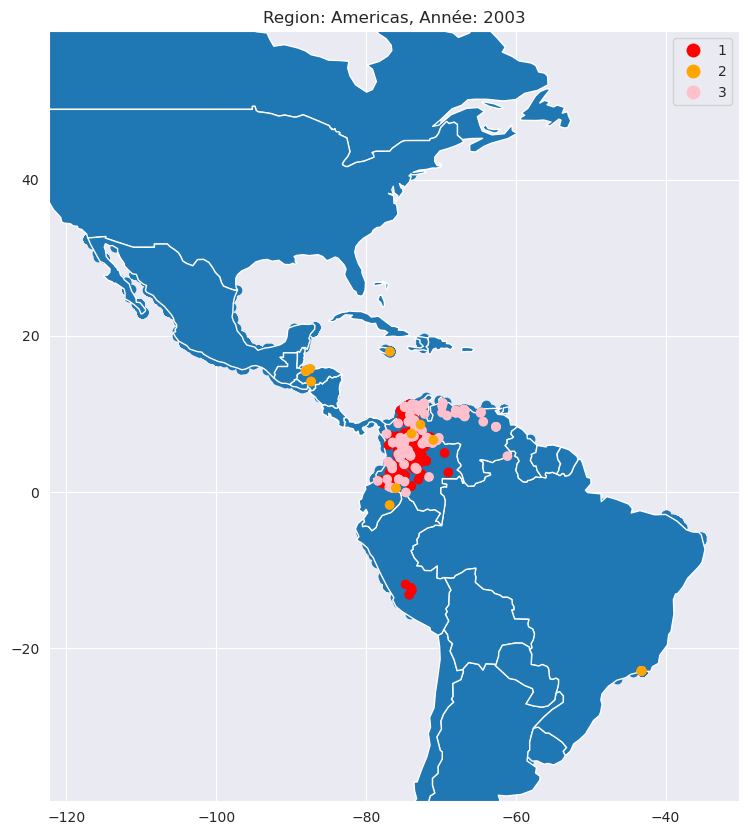

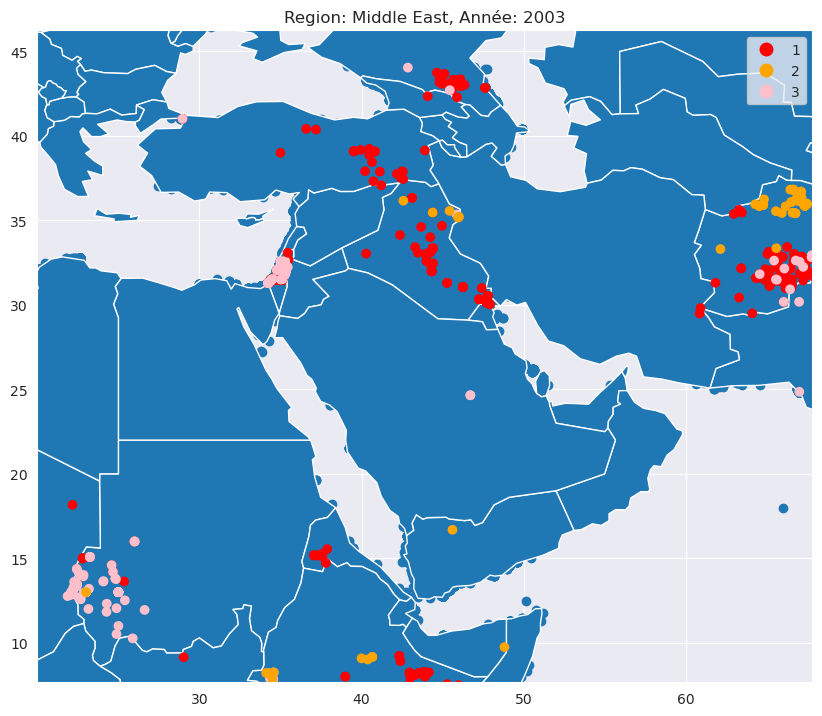

In [35]:
hot_point_by_year(2003)

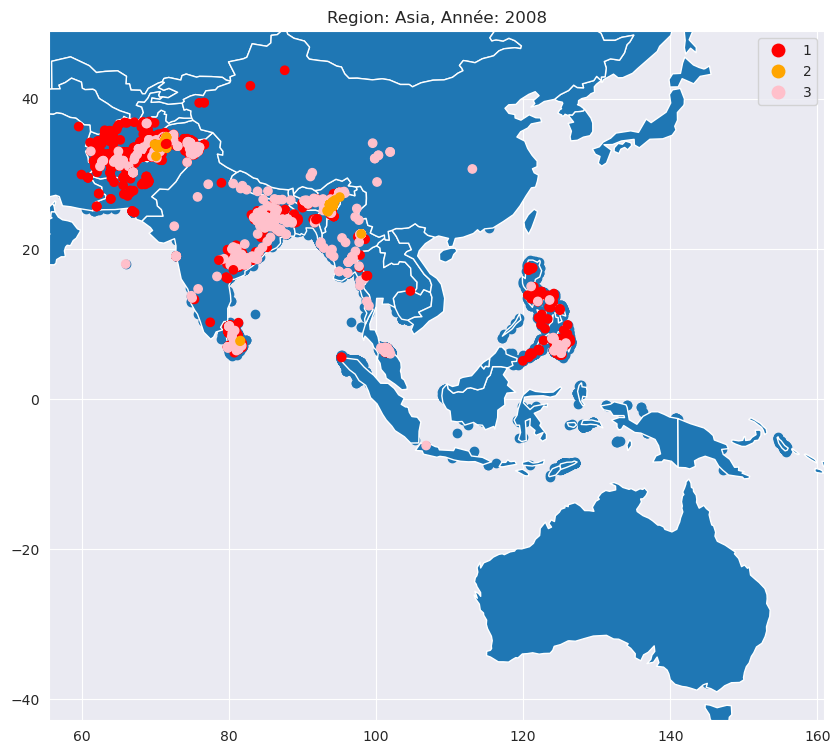

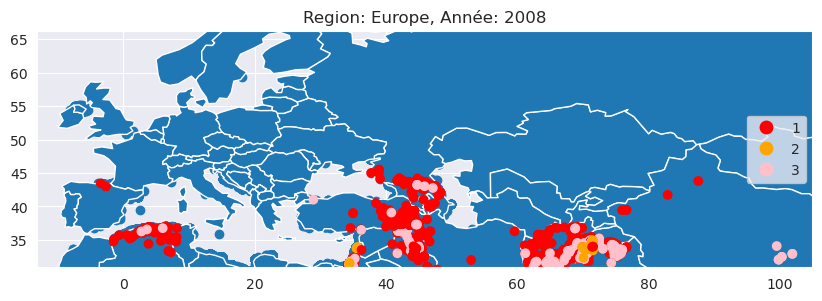

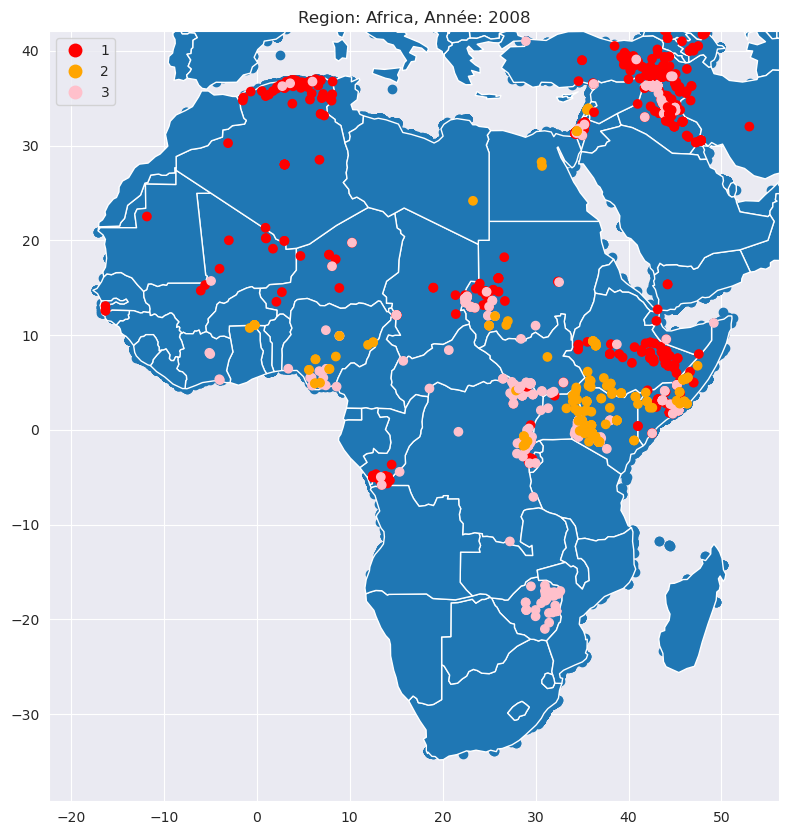

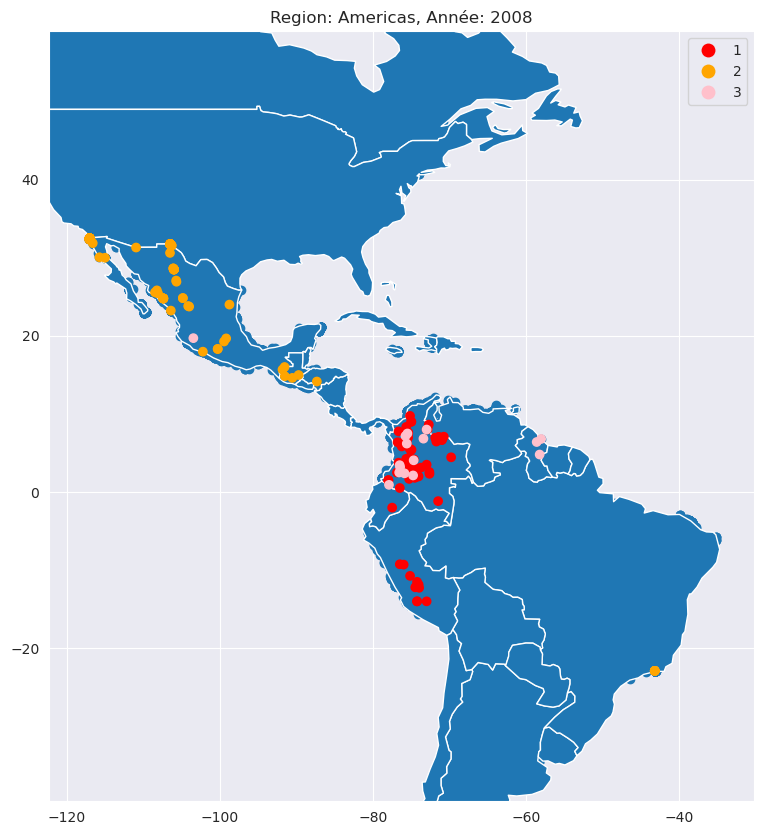

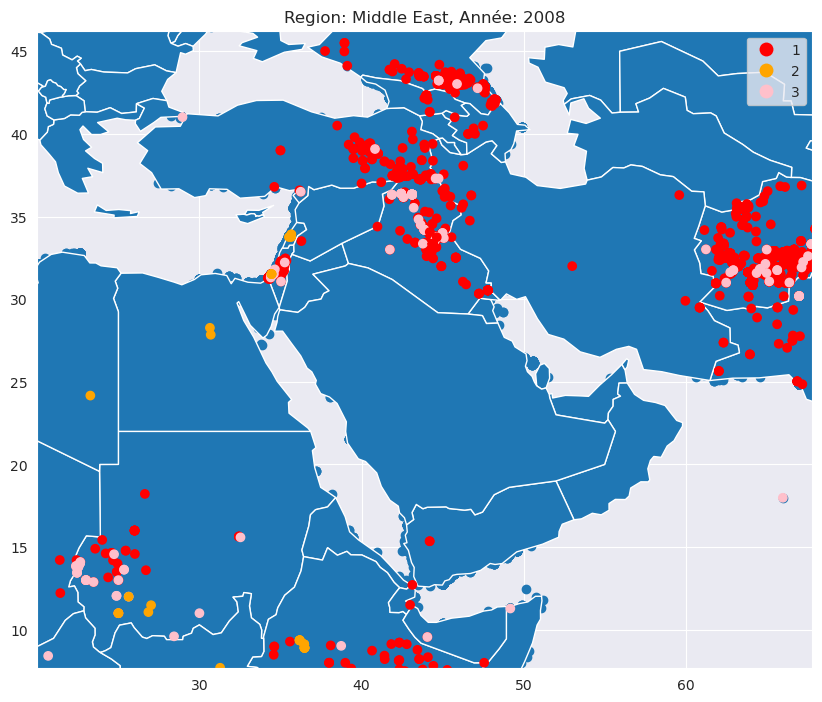

In [36]:
hot_point_by_year(2008)

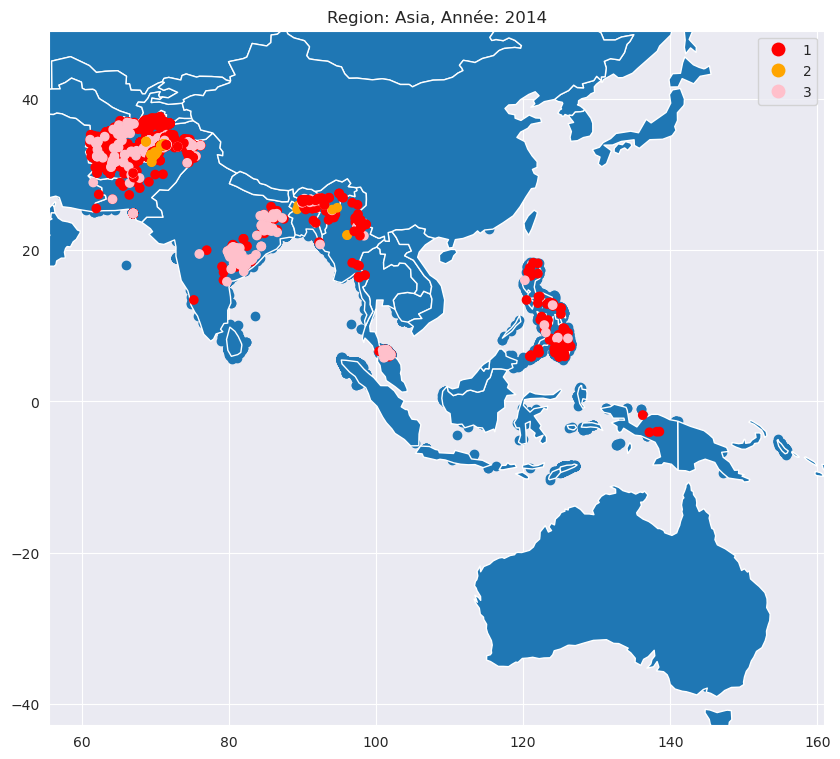

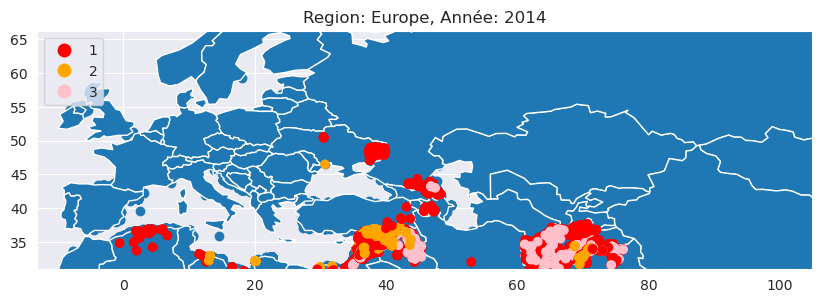

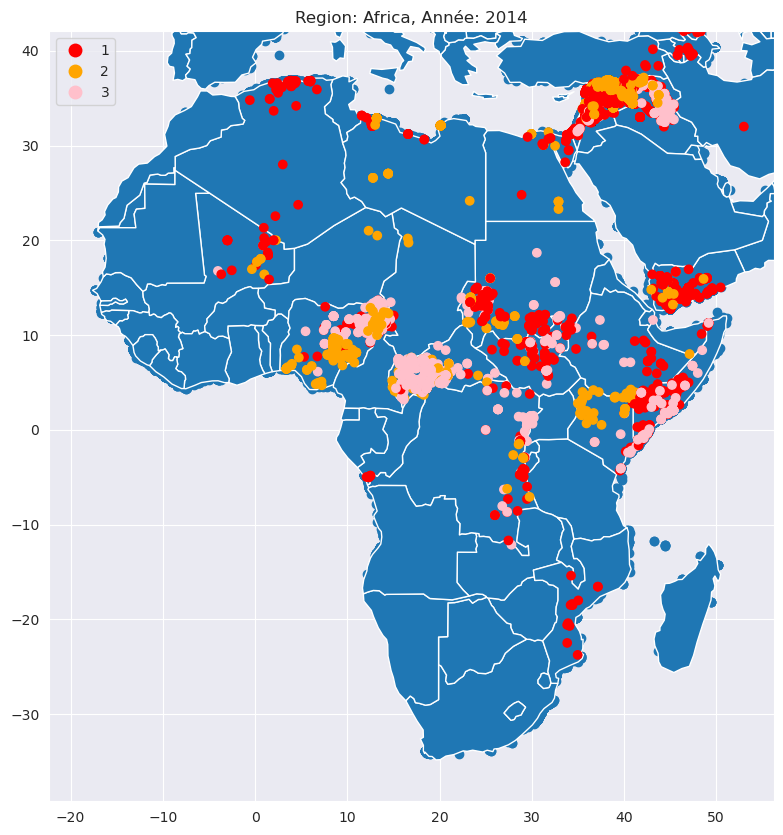

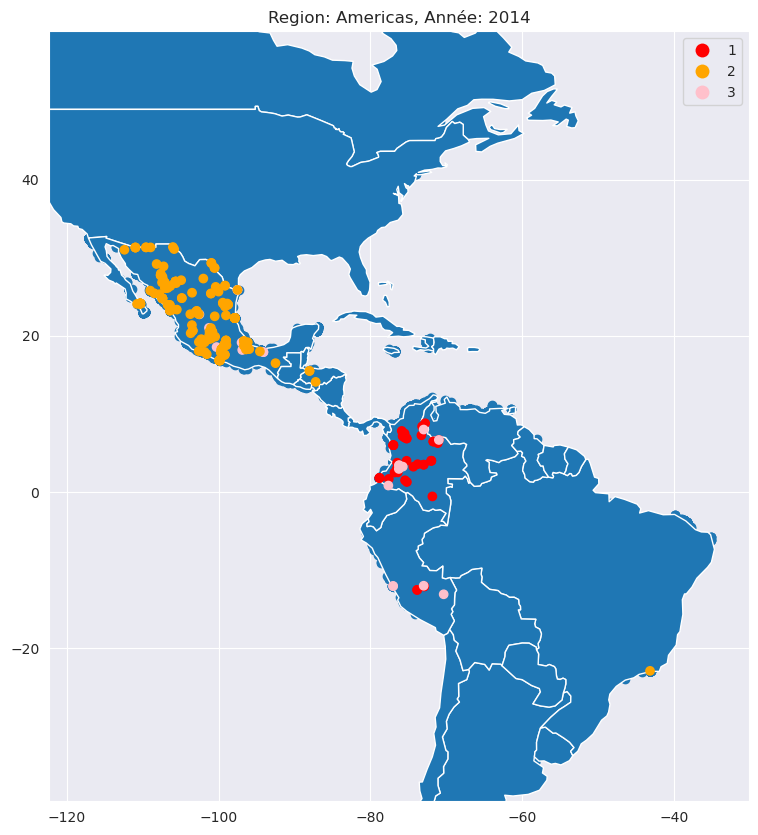

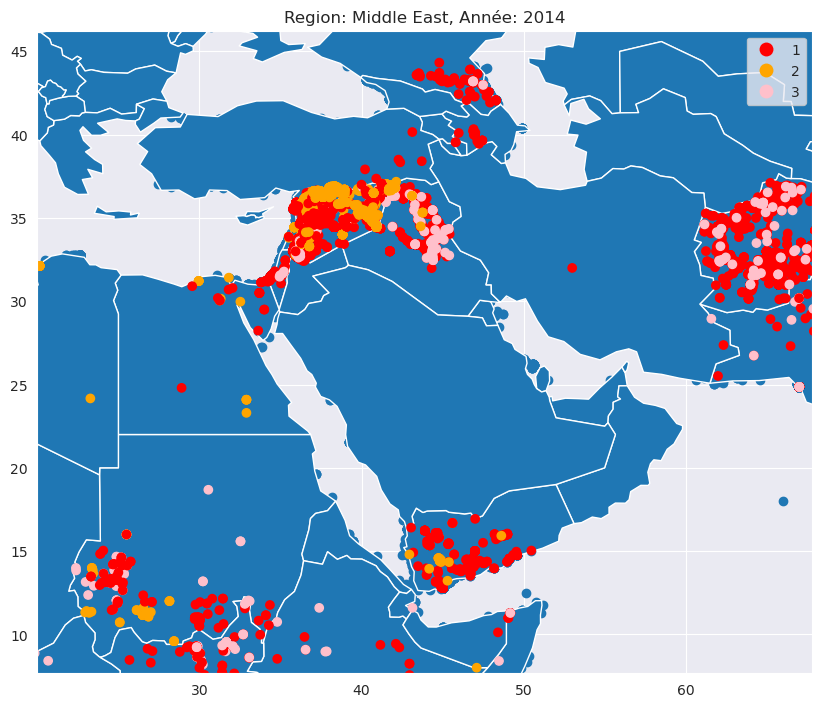

In [37]:
hot_point_by_year(2014)

In [ ]:
hot_point_by_year(2015)

In [ ]:
hot_point_by_year(2016)

In [ ]:
hot_point_by_year(2019)

# ZONE d'EXPLOITATION DU DATASET
- une frappe pour un couple latitude longitude20
- intensité du conflit nombre de décès
- intensité de la frappe de faible à forte
- suivre  le dataset en time series
- predire la probabilité d'une frappe et de son intensité sur quelle latitude longitude dans un laps de temps donné.


# Zone de reflexion sur le model
- Graphe de connexion 
- noeud A tuple (start end) avec features ne définissant pas les résultantes de l'attaques
- noeud B tuple (longitude latitude) avec features définissant les résultantes de l'attaque
- lien edge entre A et B
- layers d'attention (GATConv ou GAT2vConv ou GraphSAGE)
- layers GCN? 2?
- definir un nombre fini des cinq (ou dix mais definis) prochaines attaques quand? quelles ? intensité?
- la définition se fera sur la plus grande probabilité parmi les prédicition
- metriques ROC AUC pour la fiabilité.

#  Zone de reflexion sur un graphe
- regression linéaire
- autant de edgess qu'il y a de lignes
- il n'y a "que" 11312 date de debut d'events sur 225385 enregistrements
- on anticipe un graphe à 11312 nodes sources

In [ ]:
df_dataset['date_start'].describe()

In [ ]:
import datetime

df_dataset.sort_values(by=['date_start'], inplace=True, ascending=True)

In [ ]:
df_dataset.head(100)

# exploratory and reflexion
- wee need to know where the next hit is about to appear
- we take geometry point as target
- wee need to purge dataset from noise information

In [ ]:
dates = df_dataset.info()

In [ ]:
purge_col=['deaths_a','deaths_b','deaths_civilians','deaths_unknown','number_of_sources','side_b','side_b_new_id','side_b_new_id','side_a','side_a_new_id','dyad_name','dyad_new_id','dyad_dset_id','conflict_name','conflict_dset_id','code_status','active_year','year','relid','id']

In [ ]:
df_prod=df_dataset.drop(purge_col, axis=1)

In [ ]:
df_prod.info()

In [ ]:
df_region=pd.get_dummies(df_prod.region, prefix='within',dtype=float)

In [ ]:
df_prod=pd.concat([df_prod, df_region], axis = 1)

In [ ]:
df_prod.head()

In [ ]:
purge_col2=['country', 'longitude','where_coordinates','latitude','region', 'priogrid_gid']

In [ ]:
df_prod=df_prod.drop(purge_col2, axis =1)

In [ ]:
df_prod.info()

# Target definition
- the column geom_wkt contains both latitude and longitude inner

# Edge definition
- we need now define a graph for making a sens to our data
- THe first and essential information we have is the side a in conflict to side b
- we define edges by collecting side_a_dset_id and linked to side_b_dset_id

In [ ]:
import networkx as nx

In [ ]:
G_hot_point=nx.Graph()
G_hot_point= nx.from_pandas_edgelist(df_prod, source='side_a_dset_id', target='side_b_dset_id')

In [ ]:
G_hot_point.nodes

In [ ]:
G_hot_point

In [ ]:
pyg_graph = from_networkx(G_hot_point).to(device)

In [ ]:
pip install pyg-lib -f https://data.pyg.org/whl/torch-${TORCH}+cpu.html

In [ ]:
data = Data(x=pyg_graph.x, edge_index=pyg_graph.edge_index)

In [ ]:
from torch_geometric.loader import NeighborLoader

loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node for 2 iterations
    num_neighbors=[30] * 2,
    # Use a batch size of 128 for sampling training nodes
    batch_size=128,
    input_nodes=data.x,
)

sampled_data = next(iter(loader))
print(sampled_data.batch_size)